# Text Preprocessing Solution

##### Author: Alex Sherman | alsherman@deloitte.com

#### Agenda

1. SpaCy
2. Text Tokenization, POS Tagging, Parsing, NER
3. Text Rule-based matching
4. Text Pipelines
5. Advanced SpaCy Examples

In [1]:
import os
from IPython.core.display import display, HTML
from IPython.display import Image
from configparser import ConfigParser, ExtendedInterpolation

config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../../config.ini')
DB_PATH = config['DATABASES']['PROJECT_DB_PATH']

In [2]:
# confirm DB_PATH is in the correct db directory, otherwise the rest of the code will not work
DB_PATH

'sqlite:///C:\\Users\\alsherman\\Desktop\\PycharmProjects\\firm_initiatives\\ml_guild\\raw_data\\databases\\annual_report.db'

In [3]:
# check for the names of the tables in the database
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine(DB_PATH)
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", con=engine)

,name
0,DOCUMENTS
1,SECTIONS


In [4]:
# read the oracle 10k documents 
doc_df = pd.read_sql("SELECT * FROM Documents", con=engine)
doc_df.head(3)

,document_id,path,filename,year,document_text,table_text,author,last_modified_by,created,revision,num_tables
0,1,C:\Users\alsherman\Desktop\PycharmProjects\fir...,southwest-airlines-co_annual_report_1994.docx,1994,© 1994 Southwest Airlines Co. This annual repo...,1994 1993 Percent Change Operating revenues $...,,,2018-01-03 22:40:27,0,24
1,2,C:\Users\alsherman\Desktop\PycharmProjects\fir...,southwest-airlines-co_annual_report_1995.docx,1995,Southwest Airlines Co. 1995 Annual Report OUR ...,1995 1994 Percent Change Percent Change Opera...,43945,,2018-01-03 22:40:43,0,32
2,3,C:\Users\alsherman\Desktop\PycharmProjects\fir...,southwest-airlines-co_annual_report_1996.docx,1996,Consolidated Highlights\t2 Introduction\t3 Let...,CONSOLIDATED HIGHLIGHTS (DOLLARS IN THOUSAN...,23133,,2018-01-03 22:40:58,0,24


In [5]:
# read the oracle 10k sections
df = pd.read_sql("SELECT * FROM Sections ", con=engine)
df.head(3)

,section_id,filename,section_name,section_text,criteria,section_length
0,1,southwest-airlines-co_annual_report_1994.docx,FIRST SECTION,© 1994 Southwest Airlines Co. This annual repo...,<function heading at 0x000001D4AA492EA0>,83
1,2,southwest-airlines-co_annual_report_1994.docx,TABLE OF CONTENTS CONSOLIDATED HIGHLIGHTS,(Dollars in thousands except per share amounts...,<function heading at 0x000001D4AA492EA0>,113
2,3,southwest-airlines-co_annual_report_1994.docx,NET INCOME NET INCOME PER SHARE LOW FARES,"Southwest Airlines was built, from the ground ...",<function heading at 0x000001D4AA492EA0>,1553


### Exercise

1. Create a dataframe named fees_df that stores the section_name for each section that includes the word fee in the section_text
2. Print the count of matched sections
3. Print the first five matched sections (print the section_name)

In [6]:
# create fees_df
fees_df = df[df.section_text.str.contains('fee')].section_name

# print the count of matches
print('Sections with the term fee: {}\n'.format(len(fees_df)))

# view the first five section names
for section in fees_df[0:5]:
    print(section)
    print()

Sections with the term fee: 178

DEPARTMENT OF TRANSPORTATION RANKINGS FOR 1994 SPIRIT

RESULTS OF OPERATIONS

ACQUISITION

ACCRUED LIABILITIES (IN THOUSANDS) LONG-TERM DEBT (IN THOUSANDS)

SECRET NUMBER 1 STICK TO WHAT YOU’RE GOOD AT.



In [7]:
# example text
text = df.section_text[2461]
text

'A complaint alleging violations of federal antitrust laws and seeking certification as a class action was filed against Delta Air Lines, Inc. and AirTran in the United States District Court for the Northern District of Georgia in Atlanta on May 22, 2009. The complaint alleged, among other things, that AirTran attempted to monopolize air travel in violation of Section 2 of the Sherman Act, and conspired with Delta in imposing $15-per-bag fees for the first item of checked luggage in violation of Section 1 of the Sherman Act. The initial complaint sought treble damages on behalf of a putative class of persons or entities in the United States who directly paid Delta and/or AirTran such fees on domestic flights beginning December 5, 2008. After the filing of the May 2009 complaint, various other nearly identical complaints also seeking certification as class actions were filed in federal district courts in Atlanta, Georgia; Orlando, Florida; and Las Vegas, Nevada. All of the cases were co

### SpaCy

"SpaCy is a free, open-source library for advanced Natural Language Processing (NLP) in Python.

If you're working with a lot of text, you'll eventually want to know more about it. For example, what's it about? What do the words mean in context? Who is doing what to whom? What companies and products are mentioned? Which texts are similar to each other?

SpaCy is designed specifically for production use and helps you build applications that process and "understand" large volumes of text. It can be used to build information extraction or natural language understanding systems, or to pre-process text for deep learning.

SpaCy is not research software. It's built on the latest research, but it's designed to get things done. This leads to fairly different design decisions than NLTK or CoreNLP, which were created as platforms for teaching and research. The main difference is that SpaCy is integrated and opinionated. SpaCy tries to avoid asking the user to choose between multiple algorithms that deliver equivalent functionality. Keeping the menu small lets SpaCy deliver generally better performance and developer experience."

#### Installation:
- Windows: Download Microsoft Visual C++: 
1.	Go to: https://www.visualstudio.com/downloads/#build-tools-for-visual-studio-2017
2.	Download the first link for Visual Studio Community 2017
3.	During the install select the option to install Desktop with Development C++ (see image below)

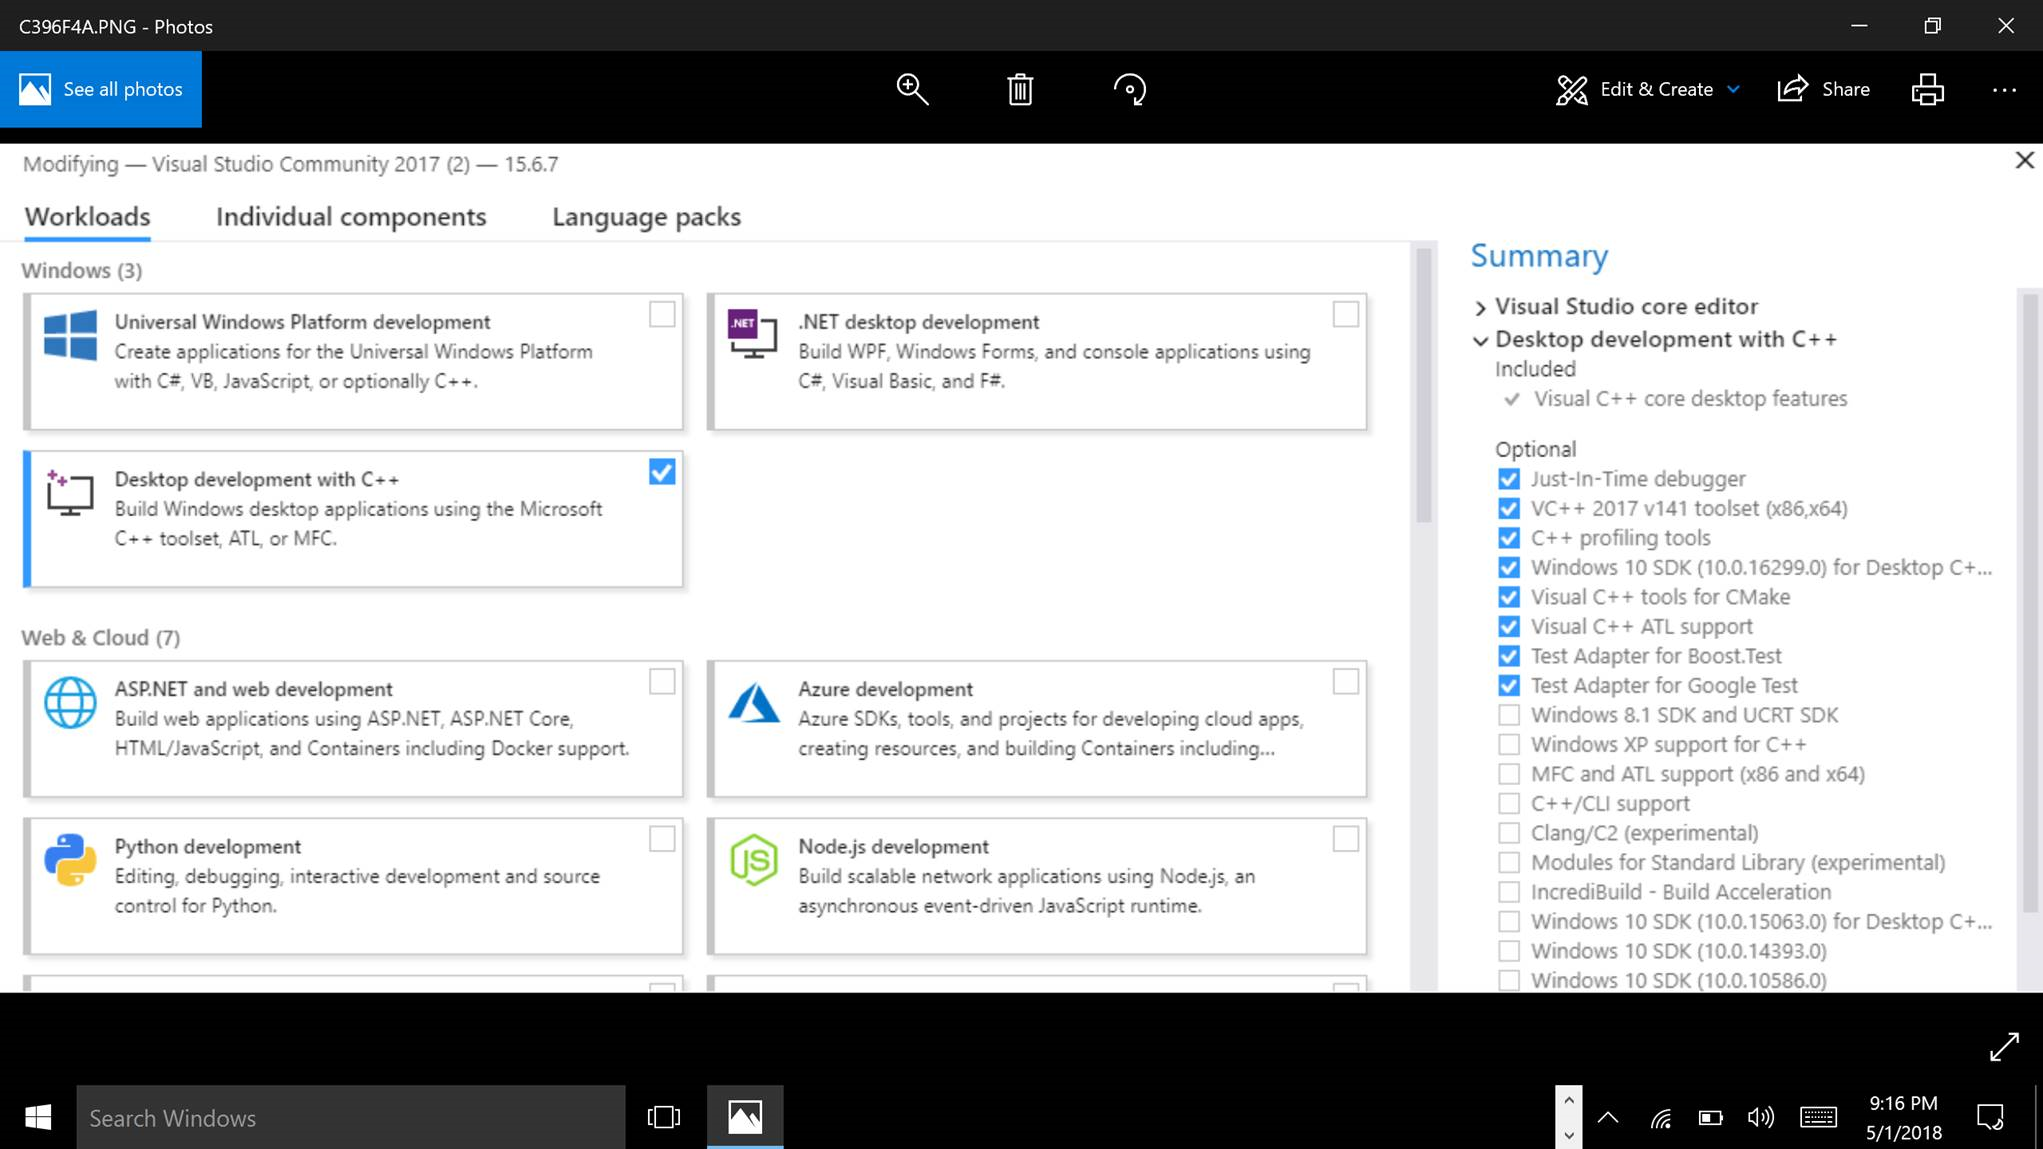

In [8]:
# Desktop with Development C++
Image("../../raw_data/images/visual_studio_community.png", width=1000)

##### SpaCy Installation
Run the following using git bash as an administrator (i.e. right click on the git bash logo and select 'Run as Admin')
- conda install -c conda-forge spacy
- python -m spacy download en

##### if you run into an error try the following:
- python -m spacy link en_core_web_sm en
- SOURCE: https://github.com/explosion/spaCy/issues/950

##### Optional to install a convolutional neural network model:
- python -m spacy download en_core_web_lg

##### Test the following code from git bash (even if previous step failed):
start python
- python -i

test if SpaCy was downloaded
- import spacy

approach 1: test if model downloaded
- nlp = spacy.load('en') 

appraoch 2: test this if spacy.load('en') failed
- import en_core_web_sm
- nlp = en_core_web_sm.load()

Optional to install a convolutional neural network model (~800MB). This is the model I will use in class
- python -m spacy download en_core_web_lg

exit Python
- exit()


##### Optional - install on an AWS EC2 instance
Instance: Amazon Linux 2 LTS Candidate 2 AMI (HVM), SSD Volume Type
#!/bin/bash

sudo yum update -y

sudo yum groupinstall 'Development Tools' -y

sudo easy_install pip

sudo yum install python-devel -y

sudo pip install spacy

sudo python -m spacy download en_core_web_lg

### SpaCy Features 

NAME |	DESCRIPTION |
:----- |:------|
Tokenization|Segmenting text into words, punctuations marks etc.|
Part-of-speech (POS) Tagging|Assigning word types to tokens, like verb or noun.|
Dependency Parsing|	Assigning syntactic dependency labels, describing the relations between individual tokens, like subject or object.|
Lemmatization|	Assigning the base forms of words. For example, the lemma of "was" is "be", and the lemma of "rats" is "rat".|
Sentence Boundary Detection (SBD)|	Finding and segmenting individual sentences.|
Named Entity Recognition (NER)|	Labelling named "real-world" objects, like persons, companies or locations.|
Similarity|	Comparing words, text spans and documents and how similar they are to each other.|
Text Classification|	Assigning categories or labels to a whole document, or parts of a document.|
Rule-based Matching|	Finding sequences of tokens based on their texts and linguistic annotations, similar to regular expressions.|
Training|	Updating and improving a statistical model's predictions.|
Serialization|	Saving objects to files or byte strings.|

SOURCE: https://spacy.io/usage/spacy-101

In [9]:
# confirm which conda environment you are using - make sure it is one with SpaCy installed
import sys
sys.executable

# if you have difficulty importing spacy try the following in git bash
# conda install ipykernel --name Python3

'C:\\Users\\alsherman\\AppData\\Local\\Continuum\\anaconda3\\envs\\guild\\python.exe'

In [10]:
import spacy
from spacy import displacy

In [11]:
%%time

# read in a simple (small) English language model
nlp = spacy.load('en')

# another approach:
# import en_core_web_sm
# nlp = en_core_web_sm.load()

Wall time: 1min 29s


In [12]:
%%time 

# read in a (large) convolutional neural network model
# this will only work after the CNN model is downloaded (~800MB)
# e.g. python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_lg') 

Wall time: 1min 45s


In [13]:
# instantiate the document text
doc = nlp(text)

In [14]:
# view the text from the SpaCy object
doc

A complaint alleging violations of federal antitrust laws and seeking certification as a class action was filed against Delta Air Lines, Inc. and AirTran in the United States District Court for the Northern District of Georgia in Atlanta on May 22, 2009. The complaint alleged, among other things, that AirTran attempted to monopolize air travel in violation of Section 2 of the Sherman Act, and conspired with Delta in imposing $15-per-bag fees for the first item of checked luggage in violation of Section 1 of the Sherman Act. The initial complaint sought treble damages on behalf of a putative class of persons or entities in the United States who directly paid Delta and/or AirTran such fees on domestic flights beginning December 5, 2008. After the filing of the May 2009 complaint, various other nearly identical complaints also seeking certification as class actions were filed in federal district courts in Atlanta, Georgia; Orlando, Florida; and Las Vegas, Nevada. All of the cases were con

In [15]:
# which the SpaCy document methods and attributes
print(dir(doc))

['_', '__bytes__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__iter__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__unicode__', '_py_tokens', '_realloc', '_vector', '_vector_norm', 'cats', 'char_span', 'count_by', 'doc', 'ents', 'extend_tensor', 'from_array', 'from_bytes', 'from_disk', 'get_extension', 'get_lca_matrix', 'has_extension', 'has_vector', 'is_parsed', 'is_tagged', 'mem', 'merge', 'noun_chunks', 'noun_chunks_iterator', 'print_tree', 'sentiment', 'sents', 'set_extension', 'similarity', 'tensor', 'text', 'text_with_ws', 'to_array', 'to_bytes', 'to_disk', 'user_data', 'user_hooks', 'user_span_hooks', 'user_token_hooks', 'vector', 'vector_norm', 'vocab']


### NLP Pipeline

When you read the text into spaCy, e.g. doc = nlp(text), you are applying a pipeline of nlp processes to the text.
by default spaCy applies a tagger, parser, and ner, but you can choose to add, replace, or remove these steps.
Note: Removing unnecessary steps for a given nlp can lead to substantial descreses in processing time.

In [13]:
# SpaCy pipeline
spacy_url = 'https://spacy.io/assets/img/pipeline.svg'
iframe = '<iframe src={} width=1000 height=200></iframe>'.format(spacy_url)
HTML(iframe)

### Tokenization

SpaCy first tokenizes the text, i.e. segments it into words, punctuation and so on. This is done by applying rules specific to each language. For example, punctuation at the end of a sentence should be split off – whereas "U.K." should remain one token. 

In [41]:
tokenization_url = 'https://spacy.io/assets/img/tokenization.svg'
iframe = '<iframe src={} width=650 height=400></iframe>'.format(tokenization_url)
HTML(iframe)

### Part-of-speech (POS) Tagging

After tokenization, spaCy can parse and tag a given Doc. This is where the statistical model comes in, which enables spaCy to make a prediction of which tag or label most likely applies in this context. A model consists of binary data and is produced by showing a system enough examples for it to make predictions that generalize across the language – for example, a word following "the" in English is most likely a noun.

Annotation | Description
:----- |:------|
Text |The original word text|
Lemma |The base form of the word.|
POS |The simple part-of-speech tag.|
Tag |The detailed part-of-speech tag.|
Dep |Syntactic dependency, i.e. the relation between tokens.|
Shape |The word shape – capitalisation, punctuation, digits.|
Is Alpha |Is the token an alpha character?|
Is Stop |Is the token part of a stop list, i.e. the most common words of the language?|

In [16]:
# import a list of stop words from SpaCy
from spacy.lang.en.stop_words import STOP_WORDS

print('Example stop words: {}'.format(list(STOP_WORDS)[0:10]))

Example stop words: ['that', 'ever', 'several', 'his', 'elsewhere', 'must', 'after', 'nevertheless', 'up', 'various']


In [22]:
nlp.vocab['that']

In [23]:
print(dir(nlp.vocab['that']))

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', 'check_flag', 'cluster', 'flags', 'from_bytes', 'has_vector', 'is_alpha', 'is_ascii', 'is_bracket', 'is_digit', 'is_left_punct', 'is_lower', 'is_oov', 'is_punct', 'is_quote', 'is_right_punct', 'is_space', 'is_stop', 'is_title', 'is_upper', 'lang', 'lang_', 'like_email', 'like_num', 'like_url', 'lower', 'lower_', 'norm', 'norm_', 'orth', 'orth_', 'prefix', 'prefix_', 'prob', 'rank', 'sentiment', 'set_attrs', 'set_flag', 'shape', 'shape_', 'similarity', 'suffix', 'suffix_', 'text', 'to_bytes', 'vector', 'vector_norm', 'vocab']


In [26]:
nlp.vocab['that'].is_stop

True

In [27]:
# search for word in the SpaCy vocabulary and
# change the is_stop attribute to True (default is False)

for word in STOP_WORDS:
    nlp.vocab[word].is_stop = True

In [28]:
# print column headers
print('{:15} | {:15} | {:8} | {:8} | {:11} | {:8} | {:8} | {:8} | '.format(
    'TEXT','LEMMA_','POS_','TAG_','DEP_','SHAPE_','IS_ALPHA','IS_STOP'))

# print various SpaCy POS attributes
for token in doc[0:20]:
    print('{:15} | {:15} | {:8} | {:8} | {:11} | {:8} | {:8} | {:8} |'.format(
          token.text, token.lemma_, token.pos_, token.tag_, token.dep_
        , token.shape_, token.is_alpha, token.is_stop))

TEXT            | LEMMA_          | POS_     | TAG_     | DEP_        | SHAPE_   | IS_ALPHA | IS_STOP  | 
A               | a               | DET      | DT       | det         | X        |        1 |        0 |
complaint       | complaint       | NOUN     | NN       | ROOT        | xxxx     |        1 |        0 |
alleging        | allege          | VERB     | VBG      | acl         | xxxx     |        1 |        0 |
violations      | violation       | NOUN     | NNS      | dobj        | xxxx     |        1 |        0 |
of              | of              | ADP      | IN       | prep        | xx       |        1 |        1 |
federal         | federal         | ADJ      | JJ       | amod        | xxxx     |        1 |        0 |
antitrust       | antitrust       | ADJ      | JJ       | amod        | xxxx     |        1 |        0 |
laws            | law             | NOUN     | NNS      | pobj        | xxxx     |        1 |        0 |
and             | and             | CCONJ    | CC     

### Text Dependency Parsing

spaCy features a fast and accurate syntactic dependency parser, and has a rich API for navigating the tree. The parser also powers the sentence boundary detection, and lets you iterate over base noun phrases, or "chunks". You can check whether a Doc  object has been parsed with the doc.is_parsed attribute, which returns a boolean value. If this attribute is False, the default sentence iterator will raise an exception.

In [57]:
# check is document has been parsed (dependency parsing)
doc.is_parsed

True

In [56]:
print('{:15} | {:10} | {:10} | {:10} | {:35} | {:25}'.format(
    'TEXT','DEP','HEAD TEXT','HEAD POS','CHILDREN','LEFTS'))

for token in doc[0:20]:
    print('{:15} | {:10} | {:10} | {:10} | {:35} | {:25}'.format(
        token.text, token.dep_, token.head.text, token.head.pos_,
        str([child for child in token.children]),str([t.text for t in token.lefts])))

TEXT            | DEP        | HEAD TEXT  | HEAD POS   | CHILDREN                            | LEFTS                    
A               | det        | complaint  | NOUN       | []                                  | []                       
complaint       | ROOT       | complaint  | NOUN       | [A, alleging, .]                    | ['A']                    
alleging        | acl        | complaint  | NOUN       | [violations, and, seeking]          | []                       
violations      | dobj       | alleging   | VERB       | [of]                                | []                       
of              | prep       | violations | NOUN       | [laws]                              | []                       
federal         | amod       | laws       | NOUN       | []                                  | []                       
antitrust       | amod       | laws       | NOUN       | []                                  | []                       
laws            | pobj       | o

#### NOUN CHUNCKS:

| **TERM** | Definition |
|:---|:---:|
| **Text** | The original noun chunk text |
| **Root text** | The original text of the word connecting the noun chunk to the rest of the parse |
| **Root dependency** | Dependency relation connecting the root to its head |
| **Root head text** | The text of the root token's head |

In [69]:
print('{:15} | {:10} | {:10} | {:40}'.format('ROOT_TEXT','ROOT','DEPENDENCY','TEXT'))

for chunk in list(doc.noun_chunks)[0:20]:
    print('{:15} | {:10} | {:10} | {:40}'.format(
        chunk.root.text, chunk.root.dep_, chunk.root.head.text, chunk.text))

ROOT_TEXT       | ROOT       | DEPENDENCY | TEXT                                    
complaint       | ROOT       | complaint  | A complaint                             
violations      | dobj       | alleging   | violations                              
laws            | pobj       | of         | federal antitrust laws                  
certification   | dobj       | seeking    | certification                           
action          | nsubjpass  | filed      | a class action                          
Lines           | pobj       | against    | Delta Air Lines                         
Inc.            | conj       | Lines      | Inc.                                    
AirTran         | conj       | Inc.       | AirTran                                 
Court           | pobj       | in         | the United States District Court        
District        | pobj       | for        | the Northern District                   
Georgia         | pobj       | of         | Georgia              

In [71]:
# dependency visualization
# after you run this code, open another browser and go to http://localhost:5000
# when you are done (before you run the next cell in the notebook) stop this cell
displacy.serve(docs=doc, style='dep')

# Another option: show visualization in Jupyter Notebook
#displacy.render(docs=doc, style='dep', jupyter=True)

### Named Entity Recognition (NER)

A named entity is a "real-world object" that's assigned a name – for example, a person, a country, a product, or a book title. spaCy can recognise various types of named entities in a document, by asking the model for a prediction. 

In [20]:
print('{:10} | {:15}'.format('LABEL','ENTITY'))

for ent in doc.ents[0:20]:
    print('{:10} | {:50}'.format(ent.label_, ent.text))

LABEL      | ENTITY         
ORG        | Delta Air Lines                                   
ORG        | AirTran                                           
GPE        | the United States District Court                  
LOC        | the Northern District                             
GPE        | Georgia                                           
GPE        | Atlanta                                           
DATE       | May 22, 2009                                      
ORG        | AirTran                                           
LAW        | Section 2                                         
LAW        | the Sherman Act                                   
ORG        | Delta                                             
ORDINAL    | first                                             
LAW        | Section 1                                         
LAW        | the Sherman Act                                   
GPE        | the United States                                 
ORG        

In [21]:
# ent methods and attributes
print(dir(ent))

['_', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__iter__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '_recalculate_indices', '_vector', '_vector_norm', 'as_doc', 'doc', 'end', 'end_char', 'ent_id', 'ent_id_', 'get_extension', 'get_lca_matrix', 'has_extension', 'has_vector', 'label', 'label_', 'lefts', 'lemma_', 'lower_', 'merge', 'n_lefts', 'n_rights', 'noun_chunks', 'orth_', 'rights', 'root', 'sent', 'sentiment', 'set_extension', 'similarity', 'start', 'start_char', 'string', 'subtree', 'text', 'text_with_ws', 'to_array', 'upper_', 'vector', 'vector_norm']


In [22]:
# entity visualization
# after you run this code, open another browser and go to http://localhost:5000
# when you are done (before you run the next cell in the notebook) stop this cell 

displacy.serve(doc, style='ent')


    Serving on port 5000...
    Using the 'ent' visualizer


    Shutting down server on port 5000.



### Exercise
1. print all the distinct entities tagged with 'LAW'
2. print all the distinct entities tagged with 'ORG'
3. print all the distinct entities tagged with 'GPE'

In [29]:
# print all the distinct entities tagged as a law
print(set(ent.text for ent in doc.ents if 'LAW' in ent.label_))

{'Section 1', 'the Sherman Act', 'Section 2 of the Sherman Act', 'Stipulation and Order', 'Section 2'}


In [30]:
# print all the distinct entities tagged as an organization
print(set(ent.text for ent in doc.ents if 'ORG' in ent.label_))

{'Delta Air Lines', 'the Consolidated Amended Complaint', 'the U.S. Department of Justice', 'American Airlines', 'the Judicial Panel', 'Delta Air  Lines', 'United Airlines', 'the Internal Revenue Service', 'Delta', 'a Civil Investigative Demand', 'Consolidated Amended Complaint', 'DOJ', 'the Company, Air Canada', 'Company', 'plaintiffs’', 'CID', 'United States District Court', 'Court', 'AirTran', 'the State of Ohio'}


In [31]:
# print all the distinct entities tagged as a geopolitical entity
print(set(ent.text for ent in doc.ents if 'GPE' in ent.label_))

{'Indiana', 'Ontario', 'the District of Columbia', 'Las Vegas', 'Illinois', 'New York', 'Connecticut', 'the United States', 'Quebec', 'Saskatchewan', 'North Carolina', 'the District of Minnesota', 'Orlando', 'the United States District Court', 'British Columbia', 'the District of Oklahoma', 'the United States District Courts', 'Louisiana', 'Atlanta', 'the District of New Jersey', 'the District of Vermont', 'Texas', 'Florida', 'California', 'Georgia', 'Multi-District  ', 'Nevada', 'Pennsylvania', 'Canada', 'Wisconsin'}


##### Collections - DefaultDict

Usually, a Python dictionary throws a KeyError if you try to get an item with a key that is not currently in the dictionary. The defaultdict in contrast will simply create any items that you try to access (provided of course they do not exist yet). To create such a "default" item, it calls the function object that you pass in the constructor (more precisely, it's an arbitrary "callable" object, which includes function and type objects). For the first example, default items are created using int(), which will return the integer object 0. For the second example, default items are created using list(), which returns a new empty list object.

In [48]:
from collections import defaultdict

In [33]:
sentence = ['The','airline','baggage','fees','and','food','fees','are','outrageous']

In [34]:
# WRONG APPROACH - KeyError!

# try to create a word count dict with new keys
d = {}
for word in sentence:
    d[word] += 1  # cannot add if the key does not exist

print(d)

KeyError: 'The'

In [35]:
d = defaultdict(int)  # define the type of data the dict stores
for word in sentence:
    d[word] += 1  # can add to unassigned keys

print(d)

defaultdict(<class 'int'>, {'fees': 2, 'and': 1, 'food': 1, 'baggage': 1, 'The': 1, 'airline': 1, 'outrageous': 1, 'are': 1})


##### Collections - Counter

A Counter is a dict subclass for counting hashable objects. It is an unordered collection where elements are stored as dictionary keys and their counts are stored as dictionary values. Counts are allowed to be any integer value including zero or negative counts. The Counter class is similar to bags or multisets in other languages.

SOURCE: https://docs.python.org/2/library/collections.html#collections.Counter

In [36]:
from collections import Counter

In [37]:
# count the number of times each GPE appears
print(Counter(ent.text for ent in doc.ents if 'GPE' in ent.label_))

Counter({'Atlanta': 3, 'New York': 3, 'the United States': 3, 'Florida': 3, 'Georgia': 3, 'Canada': 3, 'the United States District Court': 2, 'the District of Columbia': 2, 'California': 2, 'Louisiana': 1, 'Indiana': 1, 'the District of New Jersey': 1, 'Ontario': 1, 'Las Vegas': 1, 'Illinois': 1, 'Connecticut': 1, 'Quebec': 1, 'Saskatchewan': 1, 'the District of Vermont': 1, 'Texas': 1, 'North Carolina': 1, 'the District of Minnesota': 1, 'Orlando': 1, 'Multi-District  ': 1, 'Nevada': 1, 'Wisconsin': 1, 'Pennsylvania': 1, 'British Columbia': 1, 'the District of Oklahoma': 1, 'the United States District Courts': 1})


##### Iterrtools - combinations

"The itertools module standardizes a core set of fast, memory efficient tools that are useful by themselves or in combination. Together, they form an “iterator algebra” making it possible to construct specialized tools succinctly and efficiently in pure Python.

**Combinations**
- Return r length subsequences of elements from the input iterable.
- Combinations are emitted in lexicographic sort order. So, if the input iterable is sorted, the combination tuples will be produced in sorted order.
- Elements are treated as unique based on their position, not on their value. So if the input elements are unique, there will be no repeat values in each combination.

SOURCE: https://docs.python.org/3.4/library/itertools.html

In [38]:
from itertools import combinations

In [39]:
airlines = ['Southwest','American','Delta','United']
for combo in combinations(airlines, 2):
    print(combo)

('Southwest', 'American')
('Southwest', 'Delta')
('Southwest', 'United')
('American', 'Delta')
('American', 'United')
('Delta', 'United')


##### Sorted

sorted(iterable, key=None, reverse=False)

- Return a new sorted list from the items in iterable.
- Has two optional arguments which must be specified as keyword arguments.
- key specifies a function of one argument that is used to extract a comparison key from each list element: key=str.lower. The default value is None (compare the elements directly).
- reverse is a boolean value. If set to True, then the list elements are sorted as if each comparison were reversed.

SOURCE: https://docs.python.org/3/library/functions.html#sorted

In [40]:
airlines =[('airlines2',3),('airlines3',2),('airlines1',1)]

In [41]:
sorted(airlines)

[('airlines1', 1), ('airlines2', 3), ('airlines3', 2)]

In [42]:
sorted(airlines, key=lambda x:x[1])

[('airlines1', 1), ('airlines3', 2), ('airlines2', 3)]

In [43]:
sorted(airlines, key=lambda x:x[1], reverse=True)

[('airlines2', 3), ('airlines3', 2), ('airlines1', 1)]

In [44]:
# sort based on the last character of the first term
sorted(airlines, key=lambda x:x[0][-1])

[('airlines1', 1), ('airlines2', 3), ('airlines3', 2)]

### Exercise
1. Count how many time each individual entity appears
2. Create a mapping that keeps track of every combination of entities pairs that appear in the same sentence
3. Count how many times each entity combo appears
4. Print the entity combos (using sorted) in descending order

In [47]:
# dict to store all combinations of airlines that appear together 
entity_relations = defaultdict(int)

# list to sort and count how often each entity appears 
counter_entities = []

for sent in doc.sents:
    # extract entities for each sentence
    sent = nlp(sent.text)

    # store all entities tagged as an organization
    entities = [ent.text for ent in sent.ents if 'ORG' in ent.label_]

    # add the entities from the current sentence to counter_entities
    counter_entities += entities
    
    # create combinations and increment the count in entity_relations each time combo appears
    for combo in combinations(set(entities), 2):
        entity_relations[combo] += 1

In [50]:
print(Counter(counter_entities))

Counter({'AirTran': 11, 'Delta': 9, 'Company': 7, 'Court': 5, 'CID': 3, 'United Airlines': 2, 'American Airlines': 2, 'Delta Air Lines': 2, 'the Internal Revenue Service': 2, 'the U.S. Department of Justice': 1, 'United States District Court': 1, 'DOJ': 1, 'Judicial Panel': 1, 'the Consolidated Amended Complaint': 1, 'the State of Ohio': 1, 'Consolidated Amended Complaint': 1, 'Company’s': 1, 'the Company, Air Canada': 1, 'a Civil Investigative Demand': 1, 'Delta Air  Lines': 1, 'plaintiffs’': 1})


In [56]:
# view the entity pairs in descending order
sorted(entity_relations.items(), key=lambda x: x[1], reverse=True)

[(('AirTran', 'Delta'), 8),
 (('United Airlines', 'Company'), 2),
 (('Court', 'AirTran'), 2),
 (('American Airlines', 'United Airlines'), 2),
 (('American Airlines', 'Company'), 2),
 (('AirTran', 'the Consolidated Amended Complaint'), 1),
 (('the Company, Air Canada', 'Company'), 1),
 (('the State of Ohio', 'Company'), 1),
 (('CID', 'Company'), 1),
 (('CID', 'DOJ'), 1),
 (('Delta Air Lines', 'Company'), 1),
 (('a Civil Investigative Demand', 'the U.S. Department of Justice'), 1),
 (('Company’s', 'the Internal Revenue Service'), 1),
 (('the Company, Air Canada', 'Delta Air  Lines'), 1),
 (('CID', 'a Civil Investigative Demand'), 1),
 (('AirTran', 'Consolidated Amended Complaint'), 1),
 (('United Airlines', 'Delta Air Lines'), 1),
 (('CID', 'the U.S. Department of Justice'), 1),
 (('Company’s', 'Company'), 1),
 (('Court', 'Delta'), 1),
 (('AirTran', 'plaintiffs’'), 1),
 (('Delta', 'plaintiffs’'), 1),
 (('Company', 'the Internal Revenue Service'), 1),
 (('United Airlines', 'Delta Air  Lin

### Extract entity pairs from all sections with the text Southwest Airlines

In [47]:
texts = df[df.section_text.str.contains('Southwest Airlines')].section_text
len(texts)

306

In [49]:
%%time

all_ents = []
entity_relations = defaultdict(int)

for doc in nlp.pipe(texts, batch_size=100, disable=['tagger','ner']):
    # split the document into sentences
    sentences = [sentence.text for sentence in doc.sents]
    for sent in nlp.pipe(sentences, batch_size=10, disable=['parser','tagger']):
        # store all entities tagged as an organization
        entities = list(set(ent.text for ent in sent.ents if 'ORG' in ent.label_))
        # skip sentence that do not have at least 2 entities to connect 
        if len(entities) < 2:
            continue
        # store all entities to use later to filter relevant entities
        for e in entities:
            all_ents.append(e)
        # create mapping with all combonitions of entity pairs in the sentence
        for combo in combinations(entities, 2):
            entity_relations[combo] += 1
    
set(all_ents)

Wall time: 27min 44s


In [50]:
set(all_ents)

{'  ',
 '  -  ',
 '  1996',
 '  2003',
 '  21',
 '  23',
 '  333-53610',
 '  ASM',
 '  Burbank',
 '  Company',
 '  Company’s',
 '  Consolidated Balance  ',
 '  Customer   Service',
 '  Customers',
 '  December    31',
 '  December    31,',
 '  Facility',
 '  Form',
 '  Fort Lauderdale-Hollywood International Airport',
 '  Houston Hobby',
 '  Manchester',
 '  Matters',
 '  Nos',
 '  Oakland',
 '  Oklahoma',
 '  Plan',
 '  Rapid Rewards Customers',
 '  Registration',
 '  Revolving',
 '  S-8',
 '  Security',
 '  Southwest',
 '  Southwest (',
 '  Stock',
 '  Texas',
 '  Texas 75235-',
 '  United   Airlines/',
 '  at Basis',
 '  communications',
 '  of Security  ',
 '  percent',
 '  the   Company’s',
 '  the Company',
 '  the IAM',
 '  year',
 '  years',
 '10.1(b',
 '10:00a.m',
 '401(k',
 '500th Boeing',
 '8-K',
 '99.1',
 'A+ Reward',
 'AA',
 'AFA',
 'AFL- CIO',
 'AFL-CIO',
 'AFL-CIO (IAM',
 'ALPA',
 'AMFA',
 'AMR',
 'AMR Corporation',
 'ASU',
 'ATA',
 'ATA  Airlines',
 'ATA Airlines',
 'Ac

In [58]:
 airlines_map = {
 '  Southwest':'Southwest',
 '  Southwest (':'Southwest',
 '  United   Airlines/':'United',
 'ATA  Airlines':'ATA Airlines',
 'ATA Airlines':'ATA Airlines',
 'AirTran':'AirTran',
 'AirTran Airways':'AirTran',
 'AirTran Airways, Inc.':'AirTran',
 'America West Airlines':'America West Airlines',
 'American Airlines':'American',
 'American Airlines, Inc.':'American',
 'American Eagle Airlines':'American Eagle Airlines',
 'Delta':'Delta',
 'Delta Air Lines':'Delta',
 'Global Airlines':'Global Airlines',
 'JetBlue':'JetBlue',
 'Northwest Airlines':'Northwest',
 'Northwest Airlines Corporation':'Northwest',
 'Northwest Airlines/ Continental Airlines':'Northwest',
 'People Southwest Airlines':'People Southwest Airlines',
 'People of Southwest Airlines':'People Southwest Airlines',
 'Southwest':'Southwest',
 'Southwest  Airlines':'Southwest',
 'Southwest  Airlines  Co.':'Southwest',
 'Southwest Airlines':'Southwest',
 'Southwest Airlines Air Travel':'Southwest',
 'Southwest Airlines Co.':'Southwest',
 'Southwest Airlines, Co.':'Southwest',
 'US Airways':'US Airways',
 'US Airways Group':'US Airways',
 'US Airways Group, Inc.':'US Airways',
 'USAirways':'US Airways',
 'United':'United',
 'United Airlines':'United',
 'the Southwest Airlines  ':'Southwest',
 'the Southwest Airlines Co.':'Southwest'
}

In [75]:
airline_pairs = []
for items, count in entity_relations.items():
    if (items[0] in airlines_map) and (items[1] in airlines_map):
        airline1 = airlines_map[items[0]]
        airline2 = airlines_map[items[1]]
        airline_pairs.append((airline1, airline2, count))

airline_pairs

[('AirTran', 'JetBlue', 1),
 ('US Airways', 'United', 1),
 ('Delta', 'United', 1),
 ('America West Airlines', 'US Airways', 1),
 ('AirTran', 'AirTran', 13),
 ('Delta', 'Northwest', 1),
 ('Southwest', 'American Eagle Airlines', 1),
 ('AirTran', 'Southwest', 5),
 ('AirTran', 'Southwest', 2),
 ('Delta', 'US Airways', 1),
 ('Delta', 'United', 1),
 ('US Airways', 'Northwest', 1),
 ('US Airways', 'United', 1),
 ('United', 'US Airways', 1),
 ('American', 'US Airways', 1),
 ('Southwest', 'AirTran', 2),
 ('US Airways', 'American', 1),
 ('AirTran', 'Delta', 1),
 ('Southwest', 'Southwest', 23),
 ('United', 'Northwest', 1),
 ('AirTran', 'Southwest', 4),
 ('AirTran', 'Southwest', 1),
 ('America West Airlines', 'US Airways', 1),
 ('US Airways', 'United', 1),
 ('Northwest', 'United', 1),
 ('US Airways', 'Northwest', 1),
 ('Delta', 'Northwest', 1),
 ('American', 'US Airways', 1),
 ('AirTran', 'AirTran', 7)]

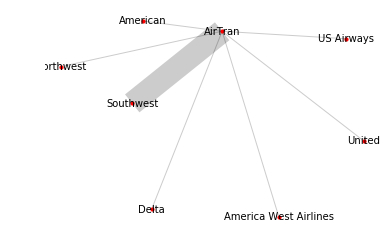

In [76]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()

for airline1, airlines2, count in airline_pairs:    
    G.add_edge(airline1, airline2, weight=count)

# positions for all nodes
pos = nx.spring_layout(G, k=5)

# nodes
nx.draw_networkx_nodes(G, pos, node_size=10)

# edges
for (u, v, d) in G.edges(data=True):
    nx.draw_networkx_edges(G, pos, edgelist=[(u,v)], width=d['weight'], alpha=.2)

# labels
nx.draw_networkx_labels(G, pos, font_size=10,  font_family='sans-serif')

plt.axis('off')
plt.show()

### Identify Relevant Text (Rule-based Matching)

Finding sequences of tokens based on their texts and linguistic annotations, similar to regular expressions. We will use this to filter and extract relevant text.

In [67]:
rule_basesd_matching_url = 'https://spacy.io/usage/linguistic-features#rule-based-matching'
iframe = '<iframe src={} width=1000 height=700></iframe>'.format(rule_basesd_matching_url)
HTML(iframe)

In [87]:
# The Matcher identifies text from rules we specify
from spacy.matcher import Matcher

In [75]:
# create a function to specify what to do with the matching text

def collect_sents(matcher, doc, i, matches):
    """  collect and transform matching text

    :param matcher: Matcher object
    :param doc: is the full document to search for text patterns
    :param i: is the index of the text matches
    :param matches: matches found in the text
    """
    
    match_id, start, end = matches[i]  # indices of matched term
    span = doc[start:end]              # extract matched term
    
    print('span: {} | start_ind:{:5} | end_ind:{:5} | id:{}'.format(
        span, start, end, match_id))

In [76]:
# set a pattern of text to collect
# find all mentions of the word fees 
pattern = [{'LOWER':'fees'}] # LOWER coverts words to lowercase before matching

# instantiate matcher
matcher = Matcher(nlp.vocab)

# add pattern to the matcher (one matcher can look for many unique patterns)
# provice a pattern name, function to apply to matches, pattern to identify
matcher.add('fee', collect_sents, pattern)

# pass the doc to the matcher to run the collect_sents function
matcher(doc)

span: fees | start_ind:   80 | end_ind:   81 | id:7125196598045271428
span: fees | start_ind:  125 | end_ind:  126 | id:7125196598045271428
span: fees | start_ind:  252 | end_ind:  253 | id:7125196598045271428
span: fees | start_ind:  281 | end_ind:  282 | id:7125196598045271428
span: fees | start_ind:  933 | end_ind:  934 | id:7125196598045271428


[(7125196598045271428, 80, 81),
 (7125196598045271428, 125, 126),
 (7125196598045271428, 252, 253),
 (7125196598045271428, 281, 282),
 (7125196598045271428, 933, 934)]

In [78]:
# change the function to print the sentence of the matched term (span)

def collect_sents(matcher, doc, i, matches):
    match_id, start, end = matches[i]
    span = doc[start:end]
    print('SPAN: {}'.format(span))

    # span.sent provides the sentence that contains the span
    print('SENT: {}'.format(span.sent))
    print()


# update the pattern to look for any noun preceeding the term 'fees'
pattern = [{'POS': 'NOUN', 'OP': '+'},{'LOWER':'fees'}]
matcher = Matcher(nlp.vocab)  # reinstantiate the matcher to remove previous patterns
matcher.add('fee', collect_sents, pattern)
matcher(doc)

SPAN: bag fees
SENT: The complaint alleged, among other things, that AirTran attempted to monopolize air travel in violation of Section 2 of the Sherman Act, and conspired with Delta in imposing $15-per-bag fees for the first item of checked luggage in violation of Section 1 of the Sherman Act.

SPAN: baggage fees
SENT: In addition to treble damages for the amount of first baggage fees paid to  AirTran and to Delta, the Consolidated Amended Complaint seeks injunctive relief against a broad range of alleged anticompetitive activities, as well as attorneys’ fees.

SPAN: attorneys’ fees
SENT: In addition to treble damages for the amount of first baggage fees paid to  AirTran and to Delta, the Consolidated Amended Complaint seeks injunctive relief against a broad range of alleged anticompetitive activities, as well as attorneys’ fees.

SPAN: attorneys’ fees
SENT: The complaints seek treble damages for periods that vary among the complaints, costs, attorneys’ fees, and injunctive relief.



[(7125196598045271428, 79, 81),
 (7125196598045271428, 251, 253),
 (7125196598045271428, 280, 282),
 (7125196598045271428, 932, 934)]

In [79]:
# change the function to collect sentences

def collect_sents(matcher, doc, i, matches):
    match_id, start, end = matches[i]
    span = doc[start:end]
        
    # update matched data collections
    matched_sents.append(span.sent)


matched_sents = []  # container for sentences
pattern = [{'POS': 'NOUN', 'OP': '+'},{'LOWER':'fees'}]
matcher = Matcher(nlp.vocab)
matcher.add('fee', collect_sents, pattern)
matcher(doc)

[(7125196598045271428, 79, 81),
 (7125196598045271428, 251, 253),
 (7125196598045271428, 280, 282),
 (7125196598045271428, 932, 934)]

In [80]:
# review matches
set(matched_sents)

{The complaint alleged, among other things, that AirTran attempted to monopolize air travel in violation of Section 2 of the Sherman Act, and conspired with Delta in imposing $15-per-bag fees for the first item of checked luggage in violation of Section 1 of the Sherman Act.,
 In addition to treble damages for the amount of first baggage fees paid to  AirTran and to Delta, the Consolidated Amended Complaint seeks injunctive relief against a broad range of alleged anticompetitive activities, as well as attorneys’ fees.,
 The complaints seek treble damages for periods that vary among the complaints, costs, attorneys’ fees, and injunctive relief.}

In [93]:
# change the function to count matches using defaultdict

def collect_sents(matcher, doc, i, matches):
    match_id, start, end = matches[i]
    span = doc[start:end]
    
    # update matched data collections
    ent_count[span.text] += 1  # defaultdict keys must use span.text not span!


ent_count = defaultdict(int)
pattern = [{'LOWER':'fees'}]
matcher = Matcher(nlp.vocab)
matcher.add('fees', collect_sents, pattern)
matcher(doc)

ent_count

defaultdict(int, {'fees': 1})

In [94]:
# update the pattern to look for a noun describing the fee

ent_count = defaultdict(int)
pattern = [{'POS': 'NOUN', 'OP': '+'},{'LOWER':'fees'}]
matcher = Matcher(nlp.vocab)
matcher.add('fees', collect_sents, pattern)
matcher(doc)

ent_count

defaultdict(int, {'Landing fees': 1})

# Pipeline

If you have a sequence of documents to process, you should use the Language.pipe()  method. The method takes an iterator of texts, and accumulates an internal buffer, which it works on in parallel. It then yields the documents in order, one-by-one.

- batch_size: number of docs to process per thread
- n_threads: number threads to use (-1 is the default that let's SpaCy decide)
- disable: Names of pipeline components to disable to speed up text processing.

In [86]:
from spacy.pipeline import Pipe

In [91]:
# get multiple sections with the term fees
# use SpaCy to determine what type of fees

texts = df[df['section_text'].str.contains('fees')]['section_text'].values[0:5]

In [92]:
%%time

ent_count = defaultdict(int) # reset defaultdict

for doc in nlp.pipe(texts): # ['parser','tagger','ner']
    matcher(doc) # match on your text

print(ent_count)

defaultdict(<class 'int'>, {'Landing fees': 2})
Wall time: 39.4 s


### SpaCy - Tips for faster processing

You can substantially speed up the time it takes SpaCy to read a document by disabling components of the NLP that are not necessary for a given task.

- Disable options: **parser, tagger, ner**

In [95]:
%%time

# reset defaultdict
ent_count = defaultdict(int)

# disable the parser and ner, as we only use POS tagging in this example
# processing occurs ~5x faster
for doc in nlp.pipe(texts, batch_size=100, disable=['parser','ner']):  
    matcher(doc) # match on your text

print(ent_count)

defaultdict(<class 'int'>, {'Landing fees': 2})
Wall time: 9.94 s


In [96]:
%%time

ent_count = defaultdict(int) # reset defaultdict

# disable the parser and ner, as we only use POS tagging in this example
# processing occurs ~75x faster, but doesn't work as the tagger is needed for the matcher
for doc in nlp.pipe(texts, batch_size=100, disable=['parser','tagger','ner']):
    matcher(doc) # match on your text

print(ent_count)

defaultdict(<class 'int'>, {})
Wall time: 659 ms


### Analyze the different risk types by year

In [83]:
# get multiple sections with the term fees
texts = df[df['section_text'].str.contains('fees')][['filename','section_text']].values
len(texts)

147

In [88]:
# These fee types were extracted using the below code. 
# For the purpose of the lesson, instead of running it twice I have pulled them out
# and grouped similar fees

fee_types = {
    'Landing fees':'landing'
  , 'agriculture inspection fees':'agriculture'
  , 'attorneys fees':'attorneys'
  , 'attorneys’ fees':'attorneys'
  , 'bag fees':'bag'
  , 'baggage fees':'bag'
  , 'card fees':'card'
  , 'card interchange fees':'card'
  , 'card processing fees':'card'
  , 'change fees':'change'
  , 'credit card fees':'card'
  , 'credit card interchange fees':'card'
  , 'credit card processing fees':'card'
  , 'customs fees':'customs'
  , 'enplanement fees':'enplanement'
  , 'experts’ fees':'experts'
  , 'inspection fees':'inspection'
  , 'interchange fees':'interchange'
  , 'l1nding fees':'landing'
  , 'landing fees':'landing'
  , 'passenger fees':'passenger'
  , 'printing fees':'printing'
  , 'processing fees':'processing'
  , 'refund passenger fees':'refund'
  , 'security fees':'security'
  , 'service fees':'service'
  , 'user fees':'user'}

In [89]:
# dict get
# returns value if key is in dict, otherwise returns a value of your choice
print(fee_types.get('user fees', 'return this if the key is not in the dict'))
print(fee_types.get('not a value', 'return this if the key is not in the dict'))

user
return this if the key is not in the dict


In [90]:
# create simple matcher function and pattern

def collect_sents(matcher, doc, i, matches):
    match_id, start, end = matches[i]
    span = doc[start:end]

    # replace the fee type
    fee = fee_types.get(span.text, span.text)
    ent_count[fee] += 1
    
pattern = [{'POS': 'NOUN', 'OP': '+'},{'LOWER':'fees'}]
matcher = Matcher(nlp.vocab)
matcher.add('risk', collect_sents, pattern)

In [91]:
%%time

years = defaultdict(dict)
for year, text in texts:
    ent_count = defaultdict(int)               # reset ent_count for each year
    doc = nlp(text, disable=['parser','ner'])  # disable unnessecary components
    matcher(doc)                               # match on your text
    
    for key, val in ent_count.items():
        years[year][key] = val

Wall time: 5min 39s


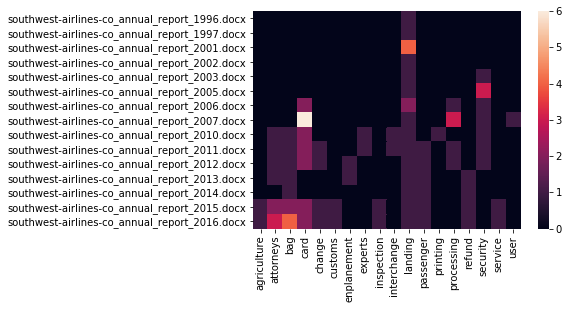

In [92]:
# view the fees by year|
%matplotlib inline
import seaborn as sns

sns.heatmap(pd.DataFrame(years).T.fillna(0))

## Advanced SpaCy (Bonus Material)

##### Text Matching: Avoid Multiple Term Matches

When using rule-based matching, SpaCy may match the same term multiple times if it is part of different n-term pairs with one term contained in another. For instance, 'integration services' in 'system integration services.'

To avoid matching these terms multiple times, we can add to the collect_sents function to check if each term is contained in the previous term

In [93]:
def collect_sents(matcher, doc, i, matches):
    match_id, start, end = matches[i]
    span = doc[start:end]
    sent = span.sent
    
    # lemmatize the matched spans
    entity = span.lemma_.lower()
            
    # explicity add the first entity without checking if it matches other terms
    # as there is no previous span to check    
    if i == 0:
        ent_count[entity] += 1
        ent_sents[entity].append(sent)
        matched_sents.append(sent)
        return

    # get the span, entity, and sentence from the previous match
    # if more than one match exist
    last_match_id, last_start, last_end = matches[i-1]
    last_span = doc[last_start : last_end]
    last_entity = last_span.text.lower()
    last_sent = last_span.sent

    # to avoid adding duplicates when one term is contained in another 
    # (e.g. 'integration services' in 'system integration services')
    # make sure new spans are unique
    distinct_entity = (entity not in last_entity) or (sent != last_sent)
    not_duplicate_entity = (entity != last_entity) or (sent != last_sent)
    
    # update collections for unique data
    if distinct_entity and not_duplicate_entity:
        ent_count[entity] += 1
        ent_sents[entity].append(sent)
        matched_sents.append(sent)

##### Multiple Patterns

SpaCy matchers can use multiple patterns. Each pattern can be added to the Matcher individually with match.add and can use their own collect_sents function. Or use *patterns to add multiple patterns to the matcher at once.

In [94]:
matched_sents = []
ent_sents  = defaultdict(list)
ent_count = defaultdict(int)

# multiple patterns
pattern = [[{'POS': 'NOUN', 'OP': '+'},{'LOWER': 'fee'}]
           , [{'POS': 'NOUN', 'OP': '+'},{'LOWER': 'fees'}]]
matcher = Matcher(nlp.vocab)

# *patterns to add multiple patterns with the same collect_sents function
matcher.add('all_fees', collect_sents, *pattern)

texts = df[df['section_text'].str.contains('fee')]['section_text'].values[0:5]
for doc in nlp.pipe(texts, batch_size=100, disable=['ner']):
    matches = matcher(doc) 

In [95]:
ent_count

defaultdict(int, {'commitment fee': 1})

In [96]:
ent_sents

defaultdict(list,
            {'commitment fee': [The commitment fee is 0.1875% per annum.]})

### Subject Verb Object (S,V,O) Extraction

SOURCES: 
- http://textacy.readthedocs.io/en/latest/_modules/textacy/extract.html#subject_verb_object_triples
- http://textacy.readthedocs.io/en/latest/_modules/textacy/spacy_utils.html#get_main_verbs_of_sent
- https://github.com/chartbeat-labs/textacy/blob/master/textacy/constants.py

In [101]:
from numpy import nanmin, nanmax, zeros, NaN
from itertools import takewhile
from spacy.parts_of_speech import CONJ, DET, NOUN, VERB
from spacy.tokens.span import Span as SpacySpan

NUMERIC_NE_TYPES = {'ORDINAL', 'CARDINAL', 'MONEY', 'QUANTITY', 'PERCENT', 'TIME', 'DATE'}
SUBJ_DEPS = {'agent', 'csubj', 'csubjpass', 'expl', 'nsubj', 'nsubjpass'}
OBJ_DEPS = {'attr', 'dobj', 'dative', 'oprd'}
AUX_DEPS = {'aux', 'auxpass', 'neg'}

def subject_verb_object_triples(doc):
    """
    Extract an ordered sequence of subject-verb-object (SVO) triples from a
    spacy-parsed doc. Note that this only works for SVO languages.

    Args:
        doc (``textacy.Doc`` or ``spacy.Doc`` or ``spacy.Span``)

    Yields:
        Tuple[``spacy.Span``, ``spacy.Span``, ``spacy.Span``]: the next 3-tuple
            of spans from ``doc`` representing a (subject, verb, object) triple,
            in order of appearance
    """
    # TODO: What to do about questions, where it may be VSO instead of SVO?
    # TODO: What about non-adjacent verb negations?
    # TODO: What about object (noun) negations?
    if isinstance(doc, SpacySpan):
        sents = [doc]
    else:  # textacy.Doc or spacy.Doc
        sents = doc.sents

    for sent in sents:
        start_i = sent[0].i

        verbs = get_main_verbs_of_sent(sent)
        for verb in verbs:
            subjs = get_subjects_of_verb(verb)
            if not subjs:
                continue
            objs = get_objects_of_verb(verb)
            if not objs:
                continue

            # add adjacent auxiliaries to verbs, for context
            # and add compounds to compound nouns
            verb_span = get_span_for_verb_auxiliaries(verb)
            verb = sent[verb_span[0] - start_i: verb_span[1] - start_i + 1]
            for subj in subjs:
                subj = sent[get_span_for_compound_noun(subj)[0] - start_i: subj.i - start_i + 1]
                for obj in objs:
                    if obj.pos == NOUN:
                        span = get_span_for_compound_noun(obj)
                    elif obj.pos == VERB:
                        span = get_span_for_verb_auxiliaries(obj)
                    else:
                        span = (obj.i, obj.i)
                    obj = sent[span[0] - start_i: span[1] - start_i + 1]

                    yield (subj, verb, obj)

def get_main_verbs_of_sent(sent):
    """Return the main (non-auxiliary) verbs in a sentence."""
    return [tok for tok in sent
            if tok.pos == VERB and tok.dep_ not in {'aux', 'auxpass'}]

def get_subjects_of_verb(verb):
    """Return all subjects of a verb according to the dependency parse."""
    subjs = [tok for tok in verb.lefts
             if tok.dep_ in SUBJ_DEPS]
    # get additional conjunct subjects
    subjs.extend(tok for subj in subjs for tok in _get_conjuncts(subj))
    return subjs

def get_objects_of_verb(verb):
    """
    Return all objects of a verb according to the dependency parse,
    including open clausal complements.
    """
    objs = [tok for tok in verb.rights
            if tok.dep_ in OBJ_DEPS]
    # get open clausal complements (xcomp)
    objs.extend(tok for tok in verb.rights
                if tok.dep_ == 'xcomp')
    # get additional conjunct objects
    objs.extend(tok for obj in objs for tok in _get_conjuncts(obj))
    return objs

def _get_conjuncts(tok):
    """
    Return conjunct dependents of the leftmost conjunct in a coordinated phrase,
    e.g. "Burton, [Dan], and [Josh] ...".
    """
    return [right for right in tok.rights
            if right.dep_ == 'conj']

def get_span_for_verb_auxiliaries(verb):
    """
    Return document indexes spanning all (adjacent) tokens
    around a verb that are auxiliary verbs or negations.
    """
    min_i = verb.i - sum(1 for _ in takewhile(lambda x: x.dep_ in AUX_DEPS,
                                              reversed(list(verb.lefts))))
    max_i = verb.i + sum(1 for _ in takewhile(lambda x: x.dep_ in AUX_DEPS,
                                              verb.rights))
    return (min_i, max_i)

def get_span_for_compound_noun(noun):
    """
    Return document indexes spanning all (adjacent) tokens
    in a compound noun.
    """
    min_i = noun.i - sum(1 for _ in takewhile(lambda x: x.dep_ == 'compound',
                                              reversed(list(noun.lefts))))
    return (min_i, noun.i)



In [102]:
triples = [(s,v,o) for s,v,o in subject_verb_object_triples(doc)]
triples

[(Southwest Airlines, has offered, class service),
 (It, ’s, idea),
 (that, has propelled, us),
 (Southwest, provides, service),
 (that, have, traffic),
 (Southwest, schedules, aircraft),
 (schedules, spoke, basis),
 (routing system, provides, routings),
 (we, minimize, connections),
 (we, minimize, delays),
 (we, minimize, travel time),
 (many, are, airports),
 (we, served, airports),
 (we, had, flights),
 (number, was, 45),
 (airports, are, Harbor),
 (airports, are, Field),
 (airports, are, Hobby),
 (airports, are, McCarran),
 (we, dominate, majority),
 (Southwest, carries, passengers)]